# Variational Inference: Bayesian Neural Networks

**This was adapted from an excellent notebook here:**
(c) 2016-2018 by Thomas Wiecki, updated by Maxim Kochurov
Original blog post: https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

## Current trends in Machine Learning

There are currently three big trends in machine learning: **Probabilistic Programming**, **Deep Learning** and "**Big Data**". Inside of PP, a lot of innovation is in making things scale using **Variational Inference**. In this blog post, I will show how to use **Variational Inference** in PyMC3 to fit a simple Bayesian Neural Network. I will also discuss how bridging Probabilistic Programming and Deep Learning can open up very interesting avenues to explore in future research.

### Probabilistic Programming at scale
**Probabilistic Programming** allows very flexible creation of custom probabilistic models and is mainly concerned with **insight** and learning from your data. The approach is inherently **Bayesian** so we can specify **priors** to inform and constrain our models and get uncertainty estimation in form of a **posterior** distribution. Using [MCMC sampling algorithms](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) we can draw samples from this posterior to very flexibly estimate these models. PyMC3 and [Stan](http://mc-stan.org/) are the current state-of-the-art tools to consruct and estimate these models. One major drawback of sampling, however, is that it's often very slow, especially for high-dimensional models. That's why more recently, **variational inference** algorithms have been developed that are almost as flexible as MCMC but much faster. Instead of drawing samples from the posterior, these algorithms instead fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem. [ADVI](http://arxiv.org/abs/1506.03431) -- Automatic Differentation Variational Inference -- is implemented in PyMC3 and [Stan](http://mc-stan.org/), as well as a new package called [Edward](https://github.com/blei-lab/edward/) which is mainly concerned with Variational Inference. 

Unfortunately, when it comes to traditional ML problems like classification or (non-linear) regression, Probabilistic Programming often plays second fiddle (in terms of accuracy and scalability) to more algorithmic approaches like [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) (e.g. [random forests](https://en.wikipedia.org/wiki/Random_forest) or [gradient boosted regression trees](https://en.wikipedia.org/wiki/Boosting_(machine_learning)).

### Deep Learning

Now in its third renaissance, deep learning has been making headlines repeatadly by dominating almost any object recognition benchmark, [kicking ass at Atari games](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), and [beating the world-champion Lee Sedol at Go](http://www.nature.com/nature/journal/v529/n7587/full/nature16961.html). From a statistical point, Neural Networks are extremely good non-linear function approximators and representation learners. While mostly known for classification, they have been extended to unsupervised learning with [AutoEncoders](https://arxiv.org/abs/1312.6114) and in all sorts of other interesting ways (e.g. [Recurrent Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), or [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html) to estimate multimodal distributions). Why do they work so well? No one really knows as the statistical properties are still not fully understood.

A large part of the innoviation in deep learning is the ability to train these extremely complex models. This rests on several pillars:
* Speed: facilitating the GPU allowed for much faster processing.
* Software: frameworks like [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/) allow flexible creation of abstract models that can then be optimized and compiled to CPU or GPU.
* Learning algorithms: training on sub-sets of the data -- stochastic gradient descent -- allows us to train these models on massive amounts of data. Techniques like drop-out avoid overfitting.
* Architectural: A lot of innovation comes from changing the input layers, like for convolutional neural nets, or the output layers, like for [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html).

### Bridging Deep Learning and Probabilistic Programming
On one hand we have *Probabilistic Programming* which allows us to build rather small and focused models in a very principled and well-understood way to gain insight into our data; on the other hand we have *deep learning* which uses many heuristics to train huge and highly complex models that are amazing at prediction. Recent innovations in variational inference allow probabilistic programming to scale model complexity as well as data size. We are thus at the cusp of being able to combine these two approaches to hopefully unlock new innovations in Machine Learning. For more motivation, see also [Dustin Tran's](https://twitter.com/dustinvtran) recent [blog post](http://dustintran.com/blog/a-quick-update-edward-and-some-motivations/).

While this would allow Probabilistic Programming to be applied to a much wider set of interesting problems, I believe this bridging also holds great promise for innovations in Deep Learning. Some ideas are:
* **Uncertainty in predictions**: As we will see below, the Bayesian Neural Network informs us about the uncertainty in its predictions. I think uncertainty is an underappreciated concept in Machine Learning as it's clearly important for real-world applications. But it could also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.
* **Uncertainty in representations**: We also get uncertainty estimates of our weights which could inform us about the stability of the learned representations of the network.
* **Regularization with priors**: Weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).
* **Transfer learning with informed priors**: If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like [GoogLeNet](https://arxiv.org/abs/1409.4842). 
* **Hierarchical Neural Networks**: A very powerful approach in Probabilistic Programming is hierarchical modeling that allows pooling of things that were learned on sub-groups to the overall population (see my tutorial on [Hierarchical Linear Regression in PyMC3](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)). Applied to Neural Networks, in hierarchical data sets, we could train individual neural nets to specialize on sub-groups while still being informed about representations of the overall population. For example, imagine a network trained to classify car models from pictures of cars. We could train a hierarchical neural network where a sub-neural network is trained to tell apart models from only a single manufacturer. The intuition being that all cars from a certain manufactures share certain similarities so it would make sense to train individual networks that specialize on brands. However, due to the individual networks being connected at a higher layer, they would still share information with the other specialized sub-networks about features that are useful to all brands. Interestingly, different layers of the network could be informed by various levels of the hierarchy -- e.g. early layers that extract visual lines could be identical in all sub-networks while the higher-order representations would be different. The hierarchical model would learn all that from the data.
* **Other hybrid architectures**: We can more freely build all kinds of neural networks. For example, Bayesian non-parametrics could be used to flexibly adjust the size and shape of the hidden layers to optimally scale the network architecture to the problem at hand during training. Currently, this requires costly hyper-parameter optimization and a lot of tribal knowledge.

## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

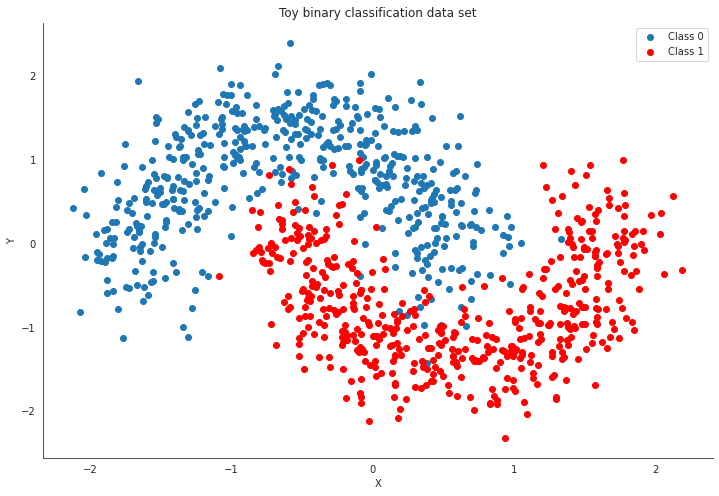

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [4]:
# just to see the dimensions o four data
print(X_train.shape)
print(Y_train.shape)

(500, 2)
(500,)


In [5]:
def util_shuffle(array1, array2, random_state):
    indices = random_state.permutation(array1.shape[0])
    shuffled_array1 = array1[indices]
    shuffled_array2 = array2[indices]
    return shuffled_array1, shuffled_array2

In [6]:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.

    Returns
    -------
    :class:`numpy:numpy.random.RandomState`
        The random state object based on `seed` parameter.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )

In [7]:
import numbers

def make_moons(n_samples=100, *, shuffle=True, noise=None, random_state=None):
    """Make two interleaving half circles.

    A simple toy dataset to visualize clustering and classification
    algorithms. Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int or tuple of shape (2,), dtype=int, default=100
        If int, the total number of points generated.
        If two-element tuple, number of points in each of two moons.

        .. versionchanged:: 0.23
           Added two-element tuple.

    shuffle : bool, default=True
        Whether to shuffle the samples.

    noise : float, default=None
        Standard deviation of Gaussian noise added to the data.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    Returns
    -------
    X : ndarray of shape (n_samples, 2)
        The generated samples.

    y : ndarray of shape (n_samples,)
        The integer labels (0 or 1) for class membership of each sample.
    """

    if isinstance(n_samples, numbers.Integral):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e

    generator = check_random_state(random_state)

    outer_circ_x = np.linspace(0, 1, n_samples_out) #np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.linspace(0, 1, n_samples_out) - 0.5 #np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = np.linspace(0, 1, n_samples_out) #1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 0.5 - np.linspace(0, 1, n_samples_out) #1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
    )

    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)

    return X, y

In [8]:
X, Y = make_moons(noise=0.05, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

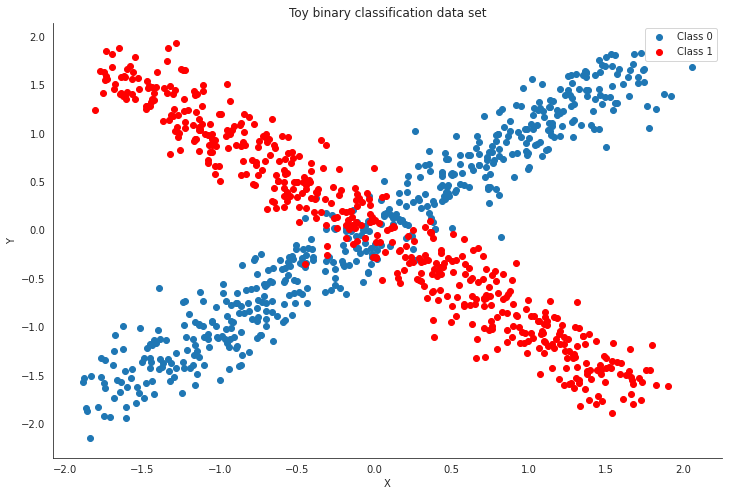

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [10]:
def construct_nn(ann_input, ann_output):
    n_hidden = 10 # Number of neurons in each hidden layer
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    #init_3 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        bias_in_1 = pm.Normal("b_in_1", 0, sd=1, shape=n_hidden, testval=np.random.randn(n_hidden).astype(float))
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        bias_1_2 = pm.Normal("b_1_2", 0, sd=1, shape=n_hidden, testval=np.random.randn(n_hidden).astype(float))
        
        # Weights from 2nd to 3rd layer
        #weights_2_3 = pm.Normal('w_2_3', 0, sd=1, 
        #                        shape=(n_hidden, n_hidden), 
        #                        testval=init_3)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        bias_2_out = pm.Normal("b_2_out", 0, sd=1, shape=n_hidden, testval=np.random.randn(n_hidden).astype(float))
        
        # Weights from hidden layer to output
        #weights_3_out = pm.Normal('w_3_out', 0, sd=1, 
        #                          shape=(n_hidden,), 
        #                          testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1) + bias_in_1)
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2) + bias_1_2)
        #act_3 = pm.math.tanh(pm.math.dot(act_2, 
        #                                 weights_2_3))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        #act_out = pm.math.sigmoid(pm.math.dot(act_3, 
        #                                      weights_3_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like NUTS which works pretty well in this case, but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use [ADVI](https://arxiv.org/abs/1603.00788) variational inference algorithm which was recently added to `PyMC3`, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [11]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [12]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

CPU times: user 1min 34s, sys: 3.69 s, total: 1min 38s
Wall time: 55.3 s


Performance wise that's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational approximation using the `sample` method (this is just sampling from Normal distributions, so not at all the same like MCMC):

In [13]:
trace = approx.sample(draws=5000)

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

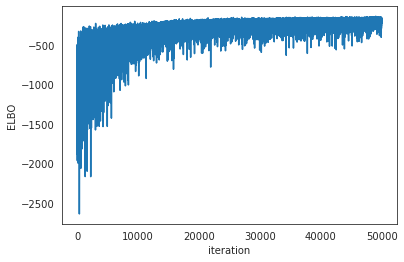

In [14]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 

In [15]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

Let's look at our predictions:

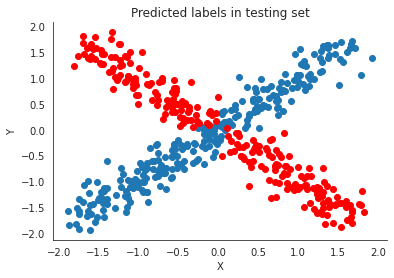

In [16]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.6%


I changed the number of neurons per layer from 5 to 10, resulting in an increase in accuracy to 56 percent. I added biases, resulting in a jump from 56 percent accuracy to 94 percent accuracy.

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [18]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [19]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

### Probability surface

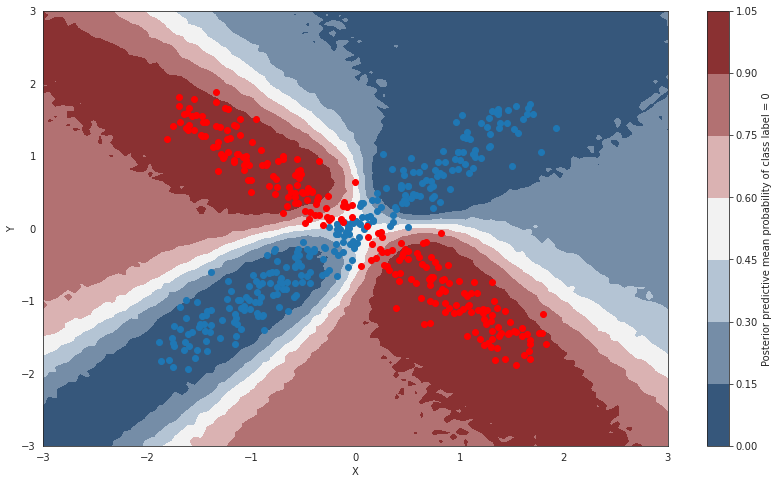

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

For the first run of this notebook:

The class probability predictions around the tails of the test data are all 90 percent or greater. The class probability predictions around the red tails are all 90 percent or greater; the class probability predictions around the blue tails are all 90 percent or greater. For the lower-right red tail, this region of high probability is the same shape as the data. Our Bayesian Neural Network (BNN) extrapolates that the region of high probability around the upper-left red tail continues toward the upper left. Similarly, our BNN extrapolates that the region of high probability around the lower-left blue tail continues toward the lower left. It makes sense that our model is uncertain of how to classify data points where data points from each class overlap at the center. Curiously, there seems to be more blue area than red area and only one area of neutrality.

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

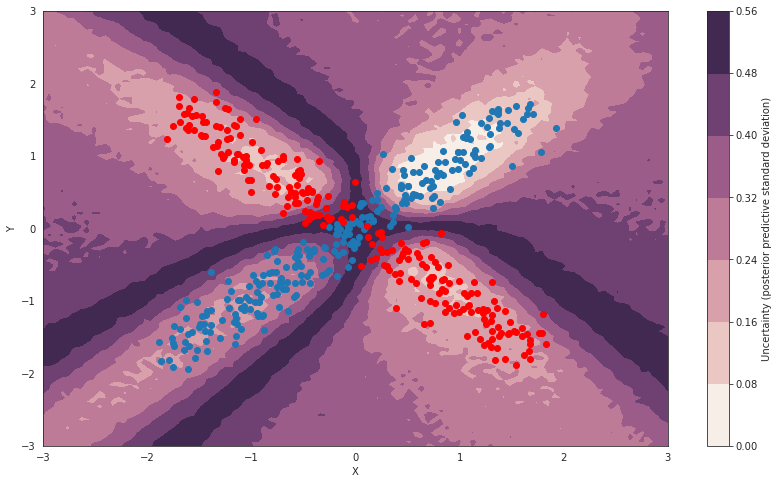

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [22]:
import numpy as np
np.max( ppc['out'].std(axis=0))

0.5

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

For the first run of this notebook:

It makes sense that regions of high class probability have low uncertainty and regions of high uncertainty have neutral class probabilities. The lowest uncertainty regions are shaped like the highest class probability regions.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [23]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(40000, method=inference)

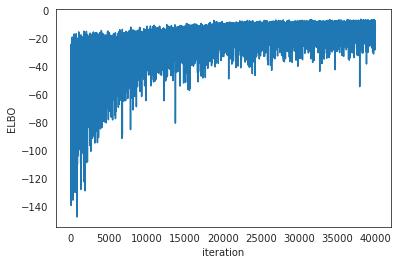

In [24]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

Explain how evidence lower bound (ELBO) and Kullback-Leibler (KL) divergence are the basis for variational inference.

Maximizing ELBO allows approximating a posterior probability density distribution with a probability density distribution of the parameters \theta. ELBO is derived via KL divergence. See https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html for derivation. Note equation 2.1. To maximize ELBO, see https://davidrmh.github.io/writing/elbo_scratch/ELBO_scratch.html .

If we minimize KL divergence, how does that change the ELBO?

See equation 2.7 at https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html . If we minimize KL divergence, we increase ELBO.

The plot of the Evidence Lower Bound (ELBO) for a Bayesian Neural Network (BNN) provides insights into the training process and convergence of the model. ELBO is commonly used as a surrogate for the log likelihood and acts as an objective function for variational inference in Bayesian models, including BNNs. Here's a discussion of the ELBO plot and its implications:

ELBO Definition:
ELBO is short for Evidence Lower Bound, and it represents a lower bound on the log marginal likelihood of the data given the model. In the context of BNNs, maximizing the ELBO is equivalent to maximizing the log likelihood of the observed data while penalizing complexity.

Training Progress:
During the training of a BNN, you typically observe the ELBO over iterations or epochs. The ELBO should generally increase over time, reflecting improvements in the model's ability to explain the observed data. However, variations and fluctuations in the ELBO are common, especially in the early stages of training.

Convergence and Stability:
A stable increase in the ELBO suggests that the model is converging and learning meaningful representations from the data. Sudden drops or fluctuations in the ELBO might indicate numerical instability or issues with the model architecture, learning rate, or other hyperparameters.

Overfitting and Model Complexity:
If the ELBO continues to increase on the training set but starts to decrease on a validation or test set, it may indicate that the model is becoming too complex and is overfitting the training data. Regularization techniques, such as dropout or weight decay, can help mitigate overfitting.

Comparison with Maximum Likelihood:
In a frequentist framework, maximum likelihood estimation aims to maximize the likelihood of the observed data. In a Bayesian framework, maximizing the ELBO is somewhat analogous to maximizing the log likelihood. However, the ELBO also includes a regularization term that penalizes model complexity. This regularization helps prevent overfitting and encourages a balance between fitting the data and keeping the model simple.

Hyperparameter Tuning:
Monitoring the ELBO can be useful for hyperparameter tuning. Adjustments to learning rates, dropout rates, or other hyperparameters can be made based on the observed behavior of the ELBO during training.

Visualizing Convergence:
Visualizing the ELBO over time allows practitioners to assess the convergence of the BNN. A well-converged model should show a smooth increase in the ELBO, and the training process might be considered complete when the ELBO plateaus.

It's important to note that ELBO alone doesn't guarantee a perfect model or optimal solution. Careful analysis of other diagnostic tools, model evaluations, and validation/test performance should accompany ELBO monitoring for a comprehensive understanding of the BNN's behavior.

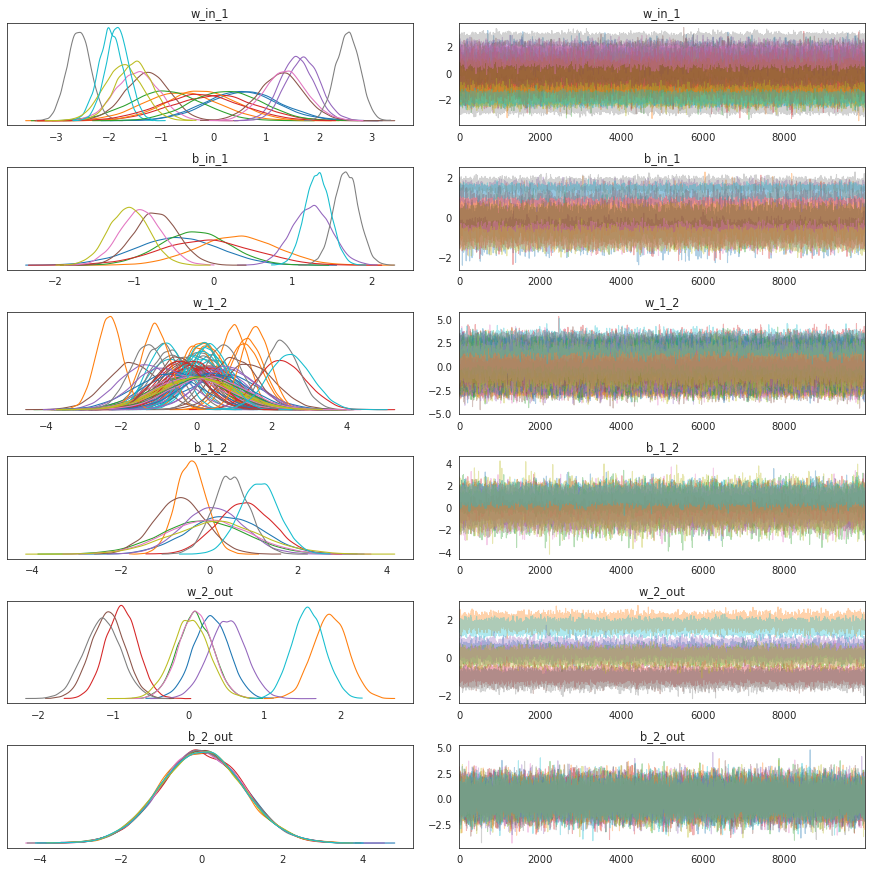

In [25]:
trace_VI = approx.sample(draws=10000)
pm.traceplot(trace_VI);

A traceplot is a graphical representation used in the context of Markov Chain Monte Carlo (MCMC) methods, which are commonly employed in statistical modeling and Bayesian analysis. The traceplot is particularly useful for assessing the convergence and mixing properties of the MCMC algorithm.

In the context of neural networks or other machine learning models, MCMC methods might be used for Bayesian inference, where uncertainty in model parameters is represented probabilistically. Here's a general explanation of what a traceplot can reveal about your network in the context of MCMC:

Convergence Assessment:
The primary purpose of a traceplot is to assess the convergence of the MCMC algorithm. If the chain has reached convergence, the traceplot should show a stable and random-looking pattern. On the other hand, if the chain hasn't converged, the traceplot may show trends, oscillations, or other patterns, indicating that the MCMC algorithm has not explored the parameter space adequately.

Mixing Properties:
Mixing refers to how well the MCMC chain explores the parameter space. A good traceplot will show that the chain is effectively sampling from the posterior distribution without getting stuck in certain regions. Poor mixing may manifest as long sequences of similar values, suggesting that the algorithm is not exploring the parameter space efficiently.

Autocorrelation:
Autocorrelation measures the degree to which a variable's values are correlated with preceding values in the chain. In an ideal case, you would want low autocorrelation, indicating that each sample is relatively independent. A traceplot can reveal the autocorrelation structure, helping to assess whether the chain is effectively exploring the parameter space or if there are issues with autocorrelation.

Burn-in Period:
The initial part of the traceplot is often referred to as the "burn-in" period. This is the time it takes for the chain to reach a region of the parameter space that is representative of the posterior distribution. By inspecting the burn-in period on the traceplot, you can determine when the MCMC chain has stabilized and disregard the earlier samples.
Multiple Chains:

If you are running multiple MCMC chains, you can compare their traceplots to check for consistency between chains. Consistent patterns across different chains can be an indication of reliable convergence.

In the context of neural networks, if your traceplot shows a stable, random-looking pattern without clear trends or oscillations, it suggests that your MCMC algorithm has likely converged, and the samples drawn from the posterior distribution are reliable for making Bayesian inferences about your network's parameters. Poor convergence or mixing, on the other hand, may indicate that adjustments to the MCMC algorithm or the model itself are needed.

Our MCMC algorithm has likely converged!

## Summary

Hopefully this blog post demonstrated a very powerful new inference algorithm available in PyMC3: [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi). I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.

## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. See my [follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

You can also run this example on the GPU by setting `device = gpu` and `floatX = float32` in your `.theanorc`.

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets, as demonstrated [here]([follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

I also presented some of this work at PyData London, view the video below:
<iframe width="560" height="315" src="https://www.youtube.com/embed/LlzVlqVzeD8" frameborder="0" allowfullscreen></iframe>

Finally, you can download this NB [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network.ipynb). Leave a comment below, and [follow me on twitter](https://twitter.com/twiecki).

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on the original ADVI implementation in PyMC3. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.